In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Prerequisites

To run this example, we first need to install several required packages, including Model Maker package that in GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [2]:
#!sudo apt -y install libportaudio2
#!pip install -q tflite-model-maker

Import the required packages.

In [3]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

C:\Users\hrips\anaconda3\envs\mobilenet\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1: Load Input Data Specific to an On-device ML App

Use `DataLoader` class to load data.

As for `from_folder()` method, it could load data from the folder. It assumes that the image data of the same class are in the same subdirectory and the subfolder name is the class name. Currently, JPEG-encoded images and PNG-encoded images are supported.

In [4]:
image_path = 'C:/Users/hrips/Desktop/Lunettes/data/'
data = DataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 20154, num_label: 10, labels: 1-lunette, 10-lunette, 2-lunette, 3-lunette, 4-lunette, 5-lunette, 6-lunette, 7-lunette, 8-lunette, 9-lunette.


Split it to training data (80%), validation data (10%, optional) and testing data (10%).

In [5]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Show 25 image examples with labels.

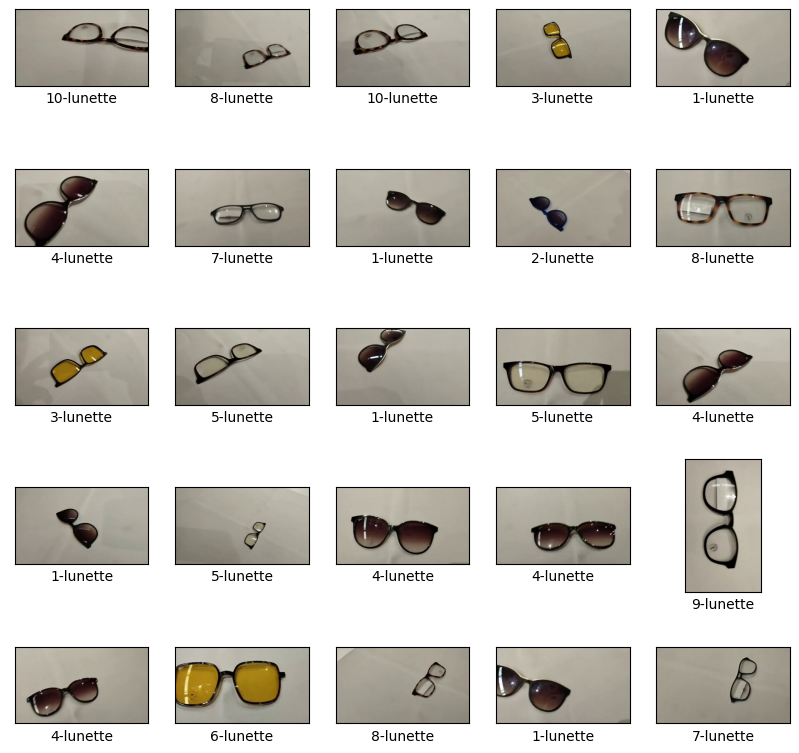

In [6]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

### Step 2: Customize the TensorFlow Model

Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0.


In [7]:
#model = image_classifier.create(train_data, validation_data=validation_data)
model = image_classifier.create(train_data,epochs=5, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             2257984   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5


C:\Users\hrips\anaconda3\envs\mobilenet\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


503/503 [==============================] - 33s 53ms/step - loss: 0.7502 - accuracy: 0.9348 - val_loss: 0.5924 - val_accuracy: 0.9926
Epoch 2/5
503/503 [==============================] - 27s 52ms/step - loss: 0.6135 - accuracy: 0.9889 - val_loss: 0.5708 - val_accuracy: 0.9970
Epoch 3/5
503/503 [==============================] - 27s 54ms/step - loss: 0.5980 - accuracy: 0.9927 - val_loss: 0.5605 - val_accuracy: 0.9975
Epoch 4/5
503/503 [==============================] - 27s 54ms/step - loss: 0.5886 - accuracy: 0.9935 - val_loss: 0.5592 - val_accuracy: 0.9965
Epoch 5/5
503/503 [==============================] - 27s 53ms/step - loss: 0.5830 - accuracy: 0.9948 - val_loss: 0.5541 - val_accuracy: 0.9975


Have a look at the detailed model structure.

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             2257984   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


### Step 3: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [9]:
loss, accuracy = model.evaluate(test_data)

63/63 [==============================] - 7s 42ms/step - loss: 0.5577 - accuracy: 0.9960


We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

63/63 [==============================] - 7s 44ms/step


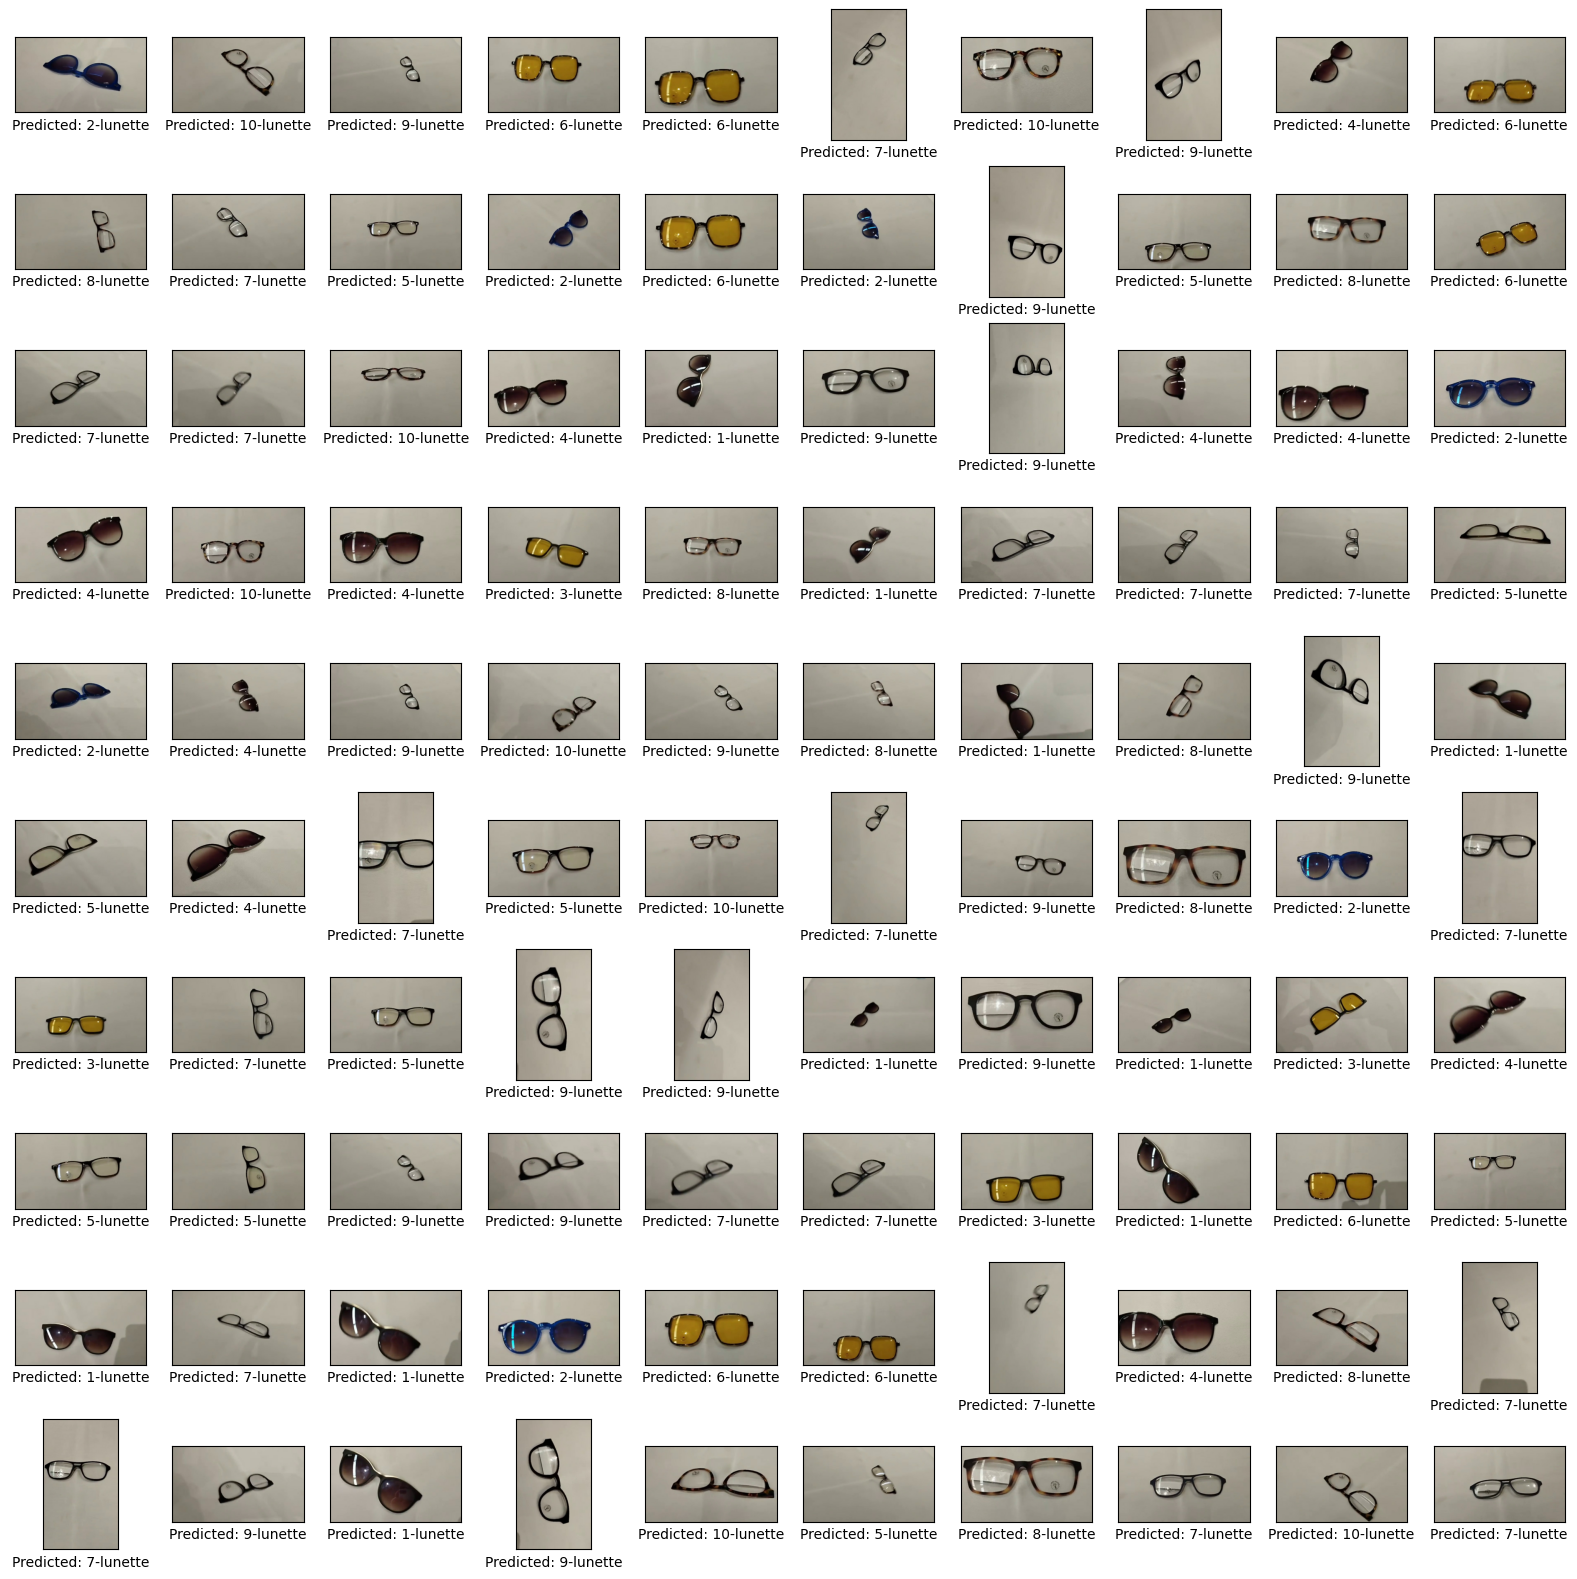

In [10]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
    if val1 == val2:
        return 'black'
    else:
        return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    predict_label = predicts[i][0][0]
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()

### Step 4: Export to TensorFlow Lite Model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/models/convert/metadata) so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster.
The default post-training quantization technique is full integer quantization for the image classification task.

In [ ]:
model.export(export_dir='C:/Users/hrips/Desktop/Lunettes/')

In [13]:
model.evaluate_tflite('C:/Users/hrips/Desktop/Lunettes/model.tflite', test_data)

{'accuracy': 0.9895833333333334}